# Práctica 2: Modelos de predicción de ventas
*Aprendizaje Automático*



# Librerías y Dependencias

In [ ]:
#Descarga de los datos de Google Drive
#!pip install gdown

#Visualización del clustering
#!pip install holoviews
#!pip install bokeh
#!pip install umap-learn
#!pip install umap-learn[plot]

In [ ]:
! pip install torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Expresiones regulares
import re

#Carga de los datos
import gdown

#Manipulación de datos
import pandas as pd
import numpy as np


#Análisis de los datos
import seaborn as sns

#Visualización de los datos
import matplotlib.pyplot as plt
#from umap import UMAP
#import umap.plot as uplot

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import math

import torch

import datetime

# Redes de neuronas recurrentes

La idea de esta sección es dar un algoritmo que pueda predecir con 1 mes vista las ventas de los productos separados del conjunto total por su alto volumen de ventas.

Para dar solución a este complejo problema se han usado redes recurentes con arquitectura de neurona de tipo **LSTM (Long Short Term Memory)**. Estas redes mejoran las redes RNN normales en cuanto a la cantida de memoria de instantes de timepo pasados. Para ello ademas de un hidden state clásico de las redes recurrentes se crea un 'cell state' que propaga la información de neuerona a neurona de la capa brindandole esa memoria. Además se hace uso de una serie de puertas 'logicas' que van sumando y restando información tanto a los valores de salida de cada capa como a el siguiente cell state.

Se presentan en esta memoria tres arquitecturas de LSTM diferentes. Para determinar de que mejor manera se puede predecir el siguiente mes de ventas se ha cogido por un lado información acumulada diaria, semanal y mensual. De este modo uno de los modelos presentados predice los 30 primeros días de manera individual y realiza la suma para computar el númeor de ventas, otro realiza el mismo acercamiento pero pronosticando las 4 semanas siguientes y finalmente el modelo sencillo mensual. Para estos modelos se han escogido ventanas temporales de 60 días, 24 semanas y 6 meses respectivamente.



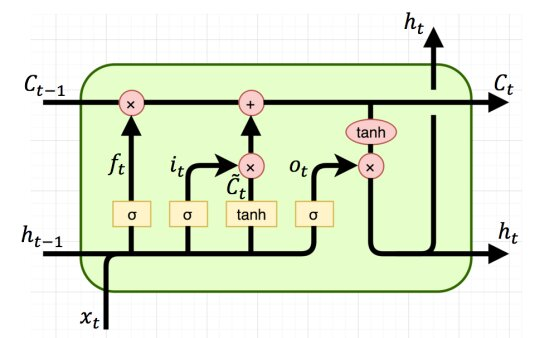

In [10]:
from IPython.display import Image
Image("Resultados/Images/lstm.jpg")

In [2]:
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
sales_complete = pd.read_csv('sales_p2_ml_V2 2.csv')
sales_reduced = pd.read_csv('sales_p2_ml.csv')
sales_complete['date'] = pd.to_datetime(sales_complete['date'], format='%d.%m.%Y')
sales_complete.drop(columns = ['Unnamed: 0'], inplace=True)
products_db = pd.read_csv('cleaned_products_db.csv')
sales_complete

,date,month_id,seller_id,prod_id,prod_price,prod_sold
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2553725,2015-03-10,26,26,13888,349.00,1.0
2553726,2015-03-12,26,26,13880,199.00,1.0
2553727,2015-03-06,26,26,13923,169.00,1.0
2553728,2015-03-29,26,59,22164,749.00,1.0


In [ ]:
#Most selled products in series
most_selled = sales_complete.groupby('prod_id').prod_sold.sum().sort_values(ascending=False).head(50).index.values.tolist()
# Selected as outliers of the other work
grouped_test = sales_reduced.groupby(['prod_id'],as_index=False).prod_sold.sum()
to_use = grouped_test[grouped_test['prod_sold']>319.0].prod_id.tolist()

In [ ]:
products_complete = sales_complete.groupby(['prod_id','month_id']).agg( total_units_sold=('prod_sold', 'sum'))
products_complete.reset_index(inplace=True)
products_complete.sort_values(by=['prod_id','month_id'])
products_complete

,prod_id,date,total_units_sold
0,0,2014-09-01,0
1,1,2014-04-02,1
2,1,2014-04-04,1
3,1,2014-07-06,1
4,1,2014-08-04,1
...,...,...,...
1312516,22168,2013-02-02,22168
1312517,22168,2013-02-17,22168
1312518,22168,2013-03-08,22168
1312519,22168,2013-09-13,22168


Inspección visual de los datos

In [ ]:
from matplotlib.pyplot import figure
for el in to_use:
    figure(figsize=(20, 8), dpi=80)
    plt.plot(products_complete.loc[products_complete['prod_id'] == el].total_units_sold.values) 
    plt.title('{} {}'.format(products_db.loc[products_db['prod_id'] == el].prod_name.values[0],el))  

## Generacion de datasets

Este apartado de generación de datasets se ha creado con el fin de crear los 3 datasets necesarios para los diferentes modelos que se presentan.

- El apartado **Generar Datos Diarios** realiza un agregado de los datos para las venta diarias de todos los productos a tener en cuenta en todas las tiendas.


- El apartado **Generar Datos Semanales** realiza lo mismo agrupando los datos por las ventas semanales de dichos productos.

- El apartado **Generar Datos Mensuales** realiza lo mismo agrupando los datos por el atributo month id.

Los conjuntos generados se utilizarán en la sección de modelos para los entrenamientos.


### Generar datos diarios 

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
def generar_atributos_desface(ts_data, var, max_lag):
    for t in range(1, max_lag+1):
        ts_data[var+'_'+str(t)] = ts_data[var].shift(-t)

def generar_datos_diarios(productos, weird_initial):
    complete_data = pd.DataFrame()
    for i,el in enumerate(productos):
        if i % 20 == 0: print(i)
        ts_by_day= products_complete.loc[products_complete['prod_id'] == el]
        ts_by_day['first_prediction_day'] = ts_by_day['date'] + pd.Timedelta(days=60)
        products_complete.sort_values(by=['date'])
        if el in weird_initial:
            ts_by_day = ts_by_day[10:]
        generar_atributos_desface(ts_by_day,'total_units_sold',89)
        ts_by_day.dropna(inplace=True)
        complete_data = pd.concat([complete_data,ts_by_day])
    first_column = complete_data.pop('first_prediction_day')
    complete_data.insert(0, 'first_prediction_day', first_column)  
    first_column = complete_data.pop('date')
    complete_data.insert(0, 'fist_input_date', first_column)
    return complete_data

In [ ]:
complete_dataset_day_prediction = generar_datos_diarios(to_use,[])

In [ ]:
complete_dataset_day_prediction

In [ ]:
#complete_dataset_day_prediction.to_csv('complete_dataset_day_prediction.csv')

### Generar datos semanales

In [ ]:
def adjust_weekday(row): 
    if (row.date.month == 12 and row.weekday == 1): return row.weekday + (52 * (row.date.year - 2012))
    else:  return row.weekday + (52 * (row.date.year - 2013))
products_complete['weekday'] = products_complete.apply(lambda row: int(row.date.strftime("%V")),axis=1)
products_complete['adjusted_weekday'] = products_complete.apply(adjust_weekday,axis=1)
products_complete

In [ ]:
sales_complete_w = products_complete.groupby(['prod_id','adjusted_weekday'], as_index=False)[['prod_id','total_units_sold',]].agg( total_units_sold=('total_units_sold', 'sum'))
sales_complete_w.sort_values(by = ['prod_id','adjusted_weekday'])
sales_complete_w

In [ ]:
def generar_datos_semanales(productos):
    complete_data = pd.DataFrame()
    for el in productos:
        ts_by_week= sales_complete_w.loc[sales_complete_w['prod_id'] == el]
        ts_by_week['first_prediction_week'] = ts_by_week['adjusted_weekday'] + 27
        ts_by_week.sort_values(by=['adjusted_weekday'])
        generar_atributos_desface(ts_by_week,'total_units_sold',6*4 + 3)
        ts_by_week.dropna(inplace=True)
        complete_data = pd.concat([complete_data,ts_by_week])
    first_column = complete_data.pop('first_prediction_week')
    complete_data.insert(0, 'first_prediction_week', first_column)
    first_column = complete_data.pop('adjusted_weekday')
    complete_data.insert(0, 'first_input_week', first_column)
    return complete_data

In [ ]:
datos_semanales = generar_datos_semanales(to_use)


In [ ]:
datos_semanales

In [ ]:
#datos_semanales.to_csv('complete_dataset_week_prediction.csv')

### Generar datos mensuales

In [ ]:
sales_complete_m = sales_complete.groupby(['prod_id','month_id'], as_index=False)[['prod_id','prod_sold',]].agg( total_units_sold=('prod_sold', 'sum'))
sales_complete_m.sort_values(by = ['prod_id','month_id'])
sales_complete_m

In [ ]:
def generar_datos_mensuales(productos):
    complete_data = pd.DataFrame()
    for el in productos:
        ts_by_month= sales_complete_m.loc[sales_complete_m['prod_id'] == el]
        ts_by_month['prediction_month'] = ts_by_month['month_id'] + 5
        ts_by_month.sort_values(by=['month_id'])
        generar_atributos_desface(ts_by_month,'total_units_sold',6)
        ts_by_month.dropna(inplace=True)
        complete_data = pd.concat([complete_data,ts_by_month])
    first_column = complete_data.pop('prediction_month')
    complete_data.insert(0, 'prediction_month', first_column)
    first_column = complete_data.pop('month_id')
    complete_data.insert(0, 'first_input_month', first_column)
    return complete_data

In [ ]:
datos_mensuales = generar_datos_mensuales(to_use)

In [ ]:
datos_mensuales

In [ ]:
#datos_mensuales.to_csv('complete_dataset_month_prediction.csv')

## Clase modelo recurrente LSTM

Este apartado presenta la **clase de la red** presentada. Esta misma clase vale para los tres modelos, unicamente modificando el valor de los parámetros del constructor de la clase para cada problema de manera específica.

Los **3 modelos** presentados más adelante presentan una **arquitectura diferente** cada una pero con una **base similar**. En las capas de entrada se presenta la arquitectura de red recurrente, que recibe los imputs y extrae de la manera más eficiente los valores de los parámetros para luego adentrarse en una Multi Layer Perceptron (fully conected) que actúa de regresor final.

El **MLP tiene una capa oculta**, de tamaño variable, **y una capa de output** de dimension el tamaño de la salida esperada. 30 en el caso diario, 4 en el caso semanal y uno en el caso mensual. 

En todos los entrenamientos se usa el **MSE para realizar el aprendizaje** y adicionalmente se printa y usa para evaluar el **MAE** devido a su facil **interpretación** en este contexto. Un MAE de 3 en el modelo diario, implica que el modelo se quivoca de medoa en 3 unidades vendidas a nivel diario.

Además se ha programado la clase Early Stopping que evita que el modelo se pase entrenando demasiado tiempo. Con un paticence y delta establecido, si la red no mejora su valor de MSE en el conjunto de validación ese número de epocas se para el entrenamiento. Devido al alto número de valores de entrenamiento y a la dificultad de hacer backpropagation con estructuras de red.



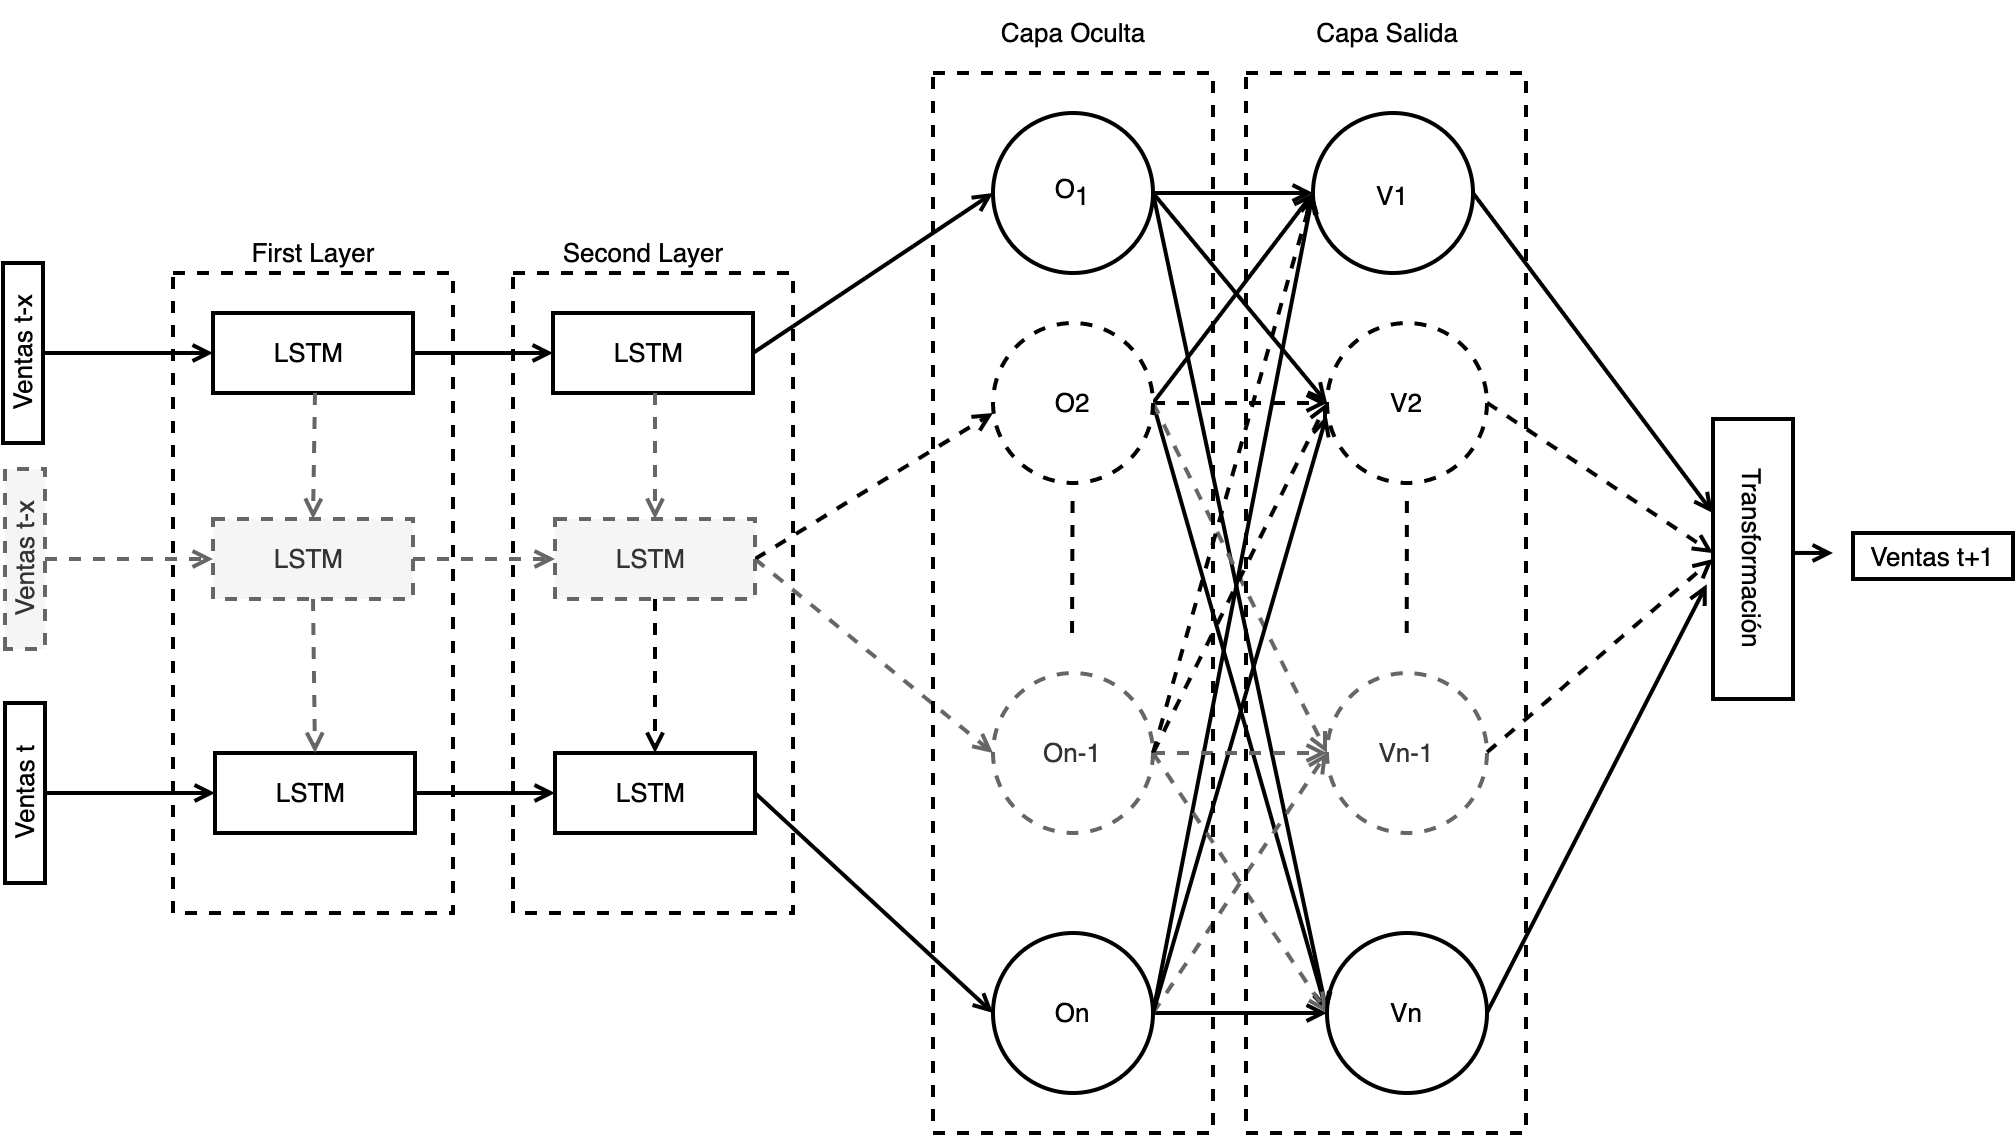

In [11]:
from IPython.display import Image
Image("Resultados/Images/arquitect.png")

In [3]:
from time import sleep
import torch
from torch import optim
from torch import nn

In [4]:

class EarlyStopping:

    def __init__(self, patience, verbose, delta=0, path='best_checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose: print('Validation has reduced from {} to {}. Saving model ...'.format(self.val_loss_min,val_loss))
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

class LSTMModel(torch.nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, num_layers, dim_feedforward,steps_to_predicts, dropout):
        
     
        super().__init__()
        self.input_dim = embedding_dim
        self.out_dim = steps_to_predicts
        
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, 
                                  dropout=dropout, batch_first=True)

        self.mlp = torch.nn.Sequential(
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.Linear(hidden_dim, dim_feedforward),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            torch.nn.Linear(dim_feedforward, steps_to_predicts),

        )
        
    def forward(self, values: torch.Tensor) -> torch.Tensor:
        

        lstm_outputs, (_, _) = self.lstm(values.view(1,1,self.input_dim))

        outputs = self.mlp(lstm_outputs)

        return outputs

class Product_LSTM(LSTMModel):
  
      def __init__(self,embedding_dim, hidden_dim, num_layers, dim_feedforward, steps_to_predicts, store_path, dropout,epochs=100,lr=0.001):
        super().__init__(embedding_dim, hidden_dim, num_layers, dim_feedforward,steps_to_predicts, dropout)  
        
        self.lr = lr 
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.MSELoss()  
        self.criterion_mae = nn.L1Loss()           

        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        self.valid_loss_mae_during_training = []

        self.store_path = store_path

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
      def trainloop(self,x_train,y_train,x_valid,y_valid):
        early_stopping = EarlyStopping(patience = 10, verbose = True, path = self.store_path)
        for e in range(int(self.epochs)):
       
            running_loss = 0.
            
            self.train()
            trainloader = zip(x_train,y_train)
            for previous_day, next_days in trainloader:
                previous_day, next_days = previous_day.to(self.device), next_days.to(self.device)

                self.optim.zero_grad()

                output = self.forward(previous_day)
              
                loss = self.criterion(output.view(self.out_dim),next_days)

                running_loss+=loss.item()

                loss.backward()

                self.optim.step()

            self.loss_during_training.append(running_loss/len(x_train))

            with torch.no_grad():            
                self.eval()
                running_loss_MSE = 0.
                running_loss_MAE = 0.

                validloader = zip(x_valid,y_valid)
                for previous_day, next_days in validloader:
                    previous_day, next_days = previous_day.to(self.device), next_days.to(self.device)
                    
                    out = self.forward(previous_day)

                    result_true = un_normalize(next_days)
                    result_predicted = un_normalize(out.view(self.out_dim))

                    loss = self.criterion(out.view(self.out_dim),next_days)
                    loss_mae = self.criterion_mae(result_true,result_predicted)

                    running_loss_MSE += loss.item()   
                    running_loss_MAE += loss_mae.item()
                    
                self.valid_loss_during_training.append(running_loss_MSE/len(x_valid))
                self.valid_loss_mae_during_training.append(running_loss_MAE/len(x_valid))
  
                    

            if(True): 

                print("Epoch %d. Training loss: %f, Validation loss: %f, Validation MAE: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1], self.valid_loss_mae_during_training[-1]))
                
            early_stopping(self.valid_loss_during_training[-1],self)
            if early_stopping.early_stop:
              print("Early stopping")
              break
              

La siguientes secciones están dedicadas a buscar los mejores modelos de red. Los tres apartados (Modelo diario, modelo semanal y modelo mensual) sigune la misma estructura.

1. Cogemos los datos correspondientes al modelo a entrenar.
2. Seccionamos el dato en conjuntos de train, test y validation. Las separaciones se han realizado de la misma manera que el anterior. 2013-01 a 2014-09 para entrenar, 2014-10 a 2014-12 para validar y finalmente el conjutno completo de 2015 para testar.
3. Se aleatorizan, estandarizan y convierten a tensores los datos correspondientes de entrada y salida. Importante puntualizar que la normalización (estandarización) se ha realizado unicamente con los valores de los conjuntos train y valid ya que suponemos que los conjuntos de test son desconocidos y no podemos usar para optimizar el modelo.
4. Se entrena el modelo.
5. Se evalua el modelo.

## Modelos 

### Modelo diario

In [ ]:
datos_ventas_diarias = pd.read_csv('complete_dataset_day_prediction.csv')
datos_ventas_diarias.drop(columns=['Unnamed: 0'], inplace=True)
datos_ventas_diarias


In [ ]:
mask_train = (datos_ventas_diarias['first_prediction_day'] > '2013-01-01') & (datos_ventas_diarias['first_prediction_day'] <= '2014-09-30')
mask_valid = (datos_ventas_diarias['first_prediction_day'] > '2014-10-01') & (datos_ventas_diarias['first_prediction_day'] <= '2014-12-31')
mask_test = (datos_ventas_diarias['first_prediction_day'] > '2014-12-31') & (datos_ventas_diarias['first_prediction_day'] <= '2015-04-01')
train_datos_ventas_diarias = datos_ventas_diarias.loc[mask_train].sort_values(by = 'fist_input_date')
train_datos_ventas_diarias.drop(columns = ['fist_input_date','first_prediction_day','prod_id'],inplace=True)
train_datos_ventas_diarias[train_datos_ventas_diarias < 0 ]= 0
valid_datos_ventas_diarias = datos_ventas_diarias.loc[mask_valid].sort_values(by = 'fist_input_date')
valid_datos_ventas_diarias.drop(columns = ['fist_input_date','first_prediction_day','prod_id'],inplace=True)
valid_datos_ventas_diarias[valid_datos_ventas_diarias < 0 ]= 0
test_datos_ventas_diarias = datos_ventas_diarias.loc[mask_test].sort_values(by = 'fist_input_date')
test_datos_ventas_diarias.drop(columns = ['fist_input_date','first_prediction_day','prod_id'],inplace=True)
test_datos_ventas_diarias[test_datos_ventas_diarias < 0 ]= 0

In [ ]:
max_value = pd.concat([train_datos_ventas_diarias,valid_datos_ventas_diarias]).max().max()
min_value = pd.concat([train_datos_ventas_diarias,valid_datos_ventas_diarias]).min().min()
print(max_value,min_value)

2144.0 0.0


In [ ]:
mean = pd.concat([train_datos_ventas_diarias,valid_datos_ventas_diarias]).mean().mean()
std = pd.concat([train_datos_ventas_diarias,valid_datos_ventas_diarias]).std().mean()
print(mean,std)

3.2961617076136216 11.493912540809033


In [ ]:
train = (train_datos_ventas_diarias - mean)/std
valid = (valid_datos_ventas_diarias- mean)/std
test = (test_datos_ventas_diarias- mean)/std

In [ ]:
train = train.sample(frac=1)
valid = valid.sample(frac=1)
test = test.sample(frac=1)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
x_train = torch.tensor(train.iloc[:, :60].values, dtype=torch.float32)
y_train = torch.tensor(train.iloc[:, 60:].values, dtype=torch.float32)

x_valid = torch.tensor(valid.iloc[:, :60].values, dtype=torch.float32)
y_valid = torch.tensor(valid.iloc[:, 60:].values, dtype=torch.float32)

x_test = torch.tensor(test.iloc[:,:60].values, dtype=torch.float32)
y_test = torch.tensor(test.iloc[:,60:].values, dtype=torch.float32)

In [ ]:
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

torch.Size([337346, 60]) torch.Size([337346, 30])
torch.Size([33771, 60]) torch.Size([33771, 30])
torch.Size([11093, 60]) torch.Size([11093, 30])


In [ ]:
def normalize(value):
    if torch.is_tensor(value): return value.subtract(mean).div(std)
    else: return (value - mean)/std

def un_normalize(value):
    if torch.is_tensor(value): return value.mul(std).add(mean)
    else: return value * std + mean

In [ ]:
prueba = Product_LSTM(embedding_dim = 60, hidden_dim = 60 , num_layers = 1, dim_feedforward = 100, steps_to_predicts = 30 ,store_path = 'best_checkpoint.pt', dropout = 0.2,epochs=30)
prueba.trainloop(x_train,y_train,x_valid,y_valid)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0. Training loss: 0.534071, Validation loss: 1.532981, Validation MAE: 2.810715
Validation has reduced from inf to 1.5329807354060705. Saving model ...
Epoch 1. Training loss: 0.470891, Validation loss: 1.302736, Validation MAE: 2.747496
Validation has reduced from 1.5329807354060705 to 1.302735592521763. Saving model ...
Epoch 2. Training loss: 0.438336, Validation loss: 1.321832, Validation MAE: 2.843803
Epoch 3. Training loss: 0.441684, Validation loss: 1.117811, Validation MAE: 2.627791
Validation has reduced from 1.302735592521763 to 1.1178112184087572. Saving model ...
Epoch 4. Training loss: 0.398912, Validation loss: 1.299798, Validation MAE: 2.832683
Epoch 5. Training loss: 0.404254, Validation loss: 1.177728, Validation MAE: 2.774911
Epoch 6. Training loss: 0.436448, Validation loss: 1.199755, Validation MAE: 2.745105
Epoch 7. Training loss: 0.379314, Validation loss: 1.376690, Validation MAE: 2.663321
Epoch 8. Training loss: 0.395602, Validation loss: 1.264785, Validat

In [ ]:
def evaluate(self,x_test,y_test,compact):
        error_unitario = 0
        error_agregado = 0
        error_mae = 0
        x_test, y_test = x_test.to(prueba.device), y_test.to(prueba.device)
        criterion_mae = nn.L1Loss() 
        with torch.no_grad():
            self.eval()
            for i in range(len(x_test)):
                out = self.forward(x_test[i])
                result_true = un_normalize(y_test[i])
                result_predicted = un_normalize(out.view(self.out_dim))
                loss_mae = criterion_mae(result_true,result_predicted)
                error_propio = result_predicted.subtract(result_true)
                error_mae += loss_mae.item()
                error_unitario += error_propio.abs().mean().item()
                if compact: 
                  error_agregado += error_propio.sum().abs().item()
        return error_unitario/len(x_test), error_agregado/len(x_test) #, error_mae/len(x_test)

In [ ]:
state_dict = torch.load('best_checkpoint.pt')
prueba.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
evaluate(prueba,x_test,y_test, True)

(3.0334752202302657, 55.1209525952184)

### Modelo semanal

In [ ]:
datos_ventas_semanales = pd.read_csv('complete_dataset_week_prediction.csv')
datos_ventas_semanales.drop(columns=['Unnamed: 0'], inplace=True)
datos_ventas_semanales

In [ ]:
mask_train = (datos_ventas_semanales['first_prediction_week'] <= 90)
mask_valid = (datos_ventas_semanales['first_prediction_week'] > 90) & (datos_ventas_semanales['first_prediction_week'] <= 103)
mask_test = (datos_ventas_semanales['first_prediction_week'] > 103) 
train_datos_ventas_semanales = datos_ventas_semanales.loc[mask_train].sort_values(by = 'first_input_week')
train_datos_ventas_semanales.drop(columns = ['first_input_week','first_prediction_week','prod_id'],inplace=True)
train_datos_ventas_semanales[train_datos_ventas_semanales < 0 ]= 0
valid_datos_ventas_semanales = datos_ventas_semanales.loc[mask_valid].sort_values(by = 'first_input_week')
valid_datos_ventas_semanales.drop(columns = ['first_input_week','first_prediction_week','prod_id'],inplace=True)
valid_datos_ventas_semanales[valid_datos_ventas_semanales < 0 ]= 0
test_datos_ventas_semanales = datos_ventas_semanales.loc[mask_test].sort_values(by = 'first_input_week')
test_datos_ventas_semanales.drop(columns = ['first_input_week','first_prediction_week','prod_id'],inplace=True)
test_datos_ventas_semanales[test_datos_ventas_semanales < 0 ]= 0

In [ ]:
max_value = pd.concat([train_datos_ventas_semanales,valid_datos_ventas_semanales]).max().max()
min_value = pd.concat([train_datos_ventas_semanales,valid_datos_ventas_semanales]).min().min()
print(max_value,min_value)

5532.0 0.0


In [ ]:
mean = pd.concat([train_datos_ventas_semanales,valid_datos_ventas_semanales]).mean().mean()
std = pd.concat([train_datos_ventas_semanales,valid_datos_ventas_semanales]).std().mean()
print(mean,std)

12.265090161586286 54.34127745411799


In [ ]:
train = (train_datos_ventas_semanales - mean)/std
valid = (valid_datos_ventas_semanales- mean)/std
test = (test_datos_ventas_semanales- mean)/std

train = train.sample(frac=1)
valid = valid.sample(frac=1)
test = test.sample(frac=1)

In [ ]:
x_train = torch.tensor(train.iloc[:, :24].values, dtype=torch.float32)
y_train = torch.tensor(train.iloc[:, 24:].values, dtype=torch.float32)

x_valid = torch.tensor(valid.iloc[:, :24].values, dtype=torch.float32)
y_valid = torch.tensor(valid.iloc[:, 24:].values, dtype=torch.float32)

x_test = torch.tensor(test.iloc[:,:24].values, dtype=torch.float32)
y_test = torch.tensor(test.iloc[:,24:].values, dtype=torch.float32)

In [ ]:
def normalize(value):
    if torch.is_tensor(value): return value.subtract(mean).div(std)
    else: return (value - mean)/std

def un_normalize(value):
    if torch.is_tensor(value): return value.mul(std).add(mean)
    else: return value * std + mean

In [ ]:
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

torch.Size([61086, 24]) torch.Size([61086, 4])
torch.Size([12718, 24]) torch.Size([12718, 4])
torch.Size([11512, 24]) torch.Size([11512, 4])


In [ ]:
prueba = Product_LSTM(embedding_dim = 24, hidden_dim = 40 , num_layers = 2, dim_feedforward = 50, steps_to_predicts = 4 ,store_path = 'best_checkpoint.pt', dropout = 0.2, epochs=30)
prueba.trainloop(x_train,y_train,x_valid,y_valid)

Epoch 0. Training loss: 0.759519, Validation loss: 0.865775, Validation MAE: 6.224988
Validation has reduced from inf to 0.8657746272934814. Saving model ...
Epoch 1. Training loss: 0.677079, Validation loss: 0.148887, Validation MAE: 5.491578
Validation has reduced from 0.8657746272934814 to 0.14888685742541038. Saving model ...
Epoch 2. Training loss: 0.635590, Validation loss: 0.388308, Validation MAE: 6.033591
Epoch 3. Training loss: 0.639867, Validation loss: 0.737035, Validation MAE: 7.944644
Epoch 4. Training loss: 0.456676, Validation loss: 0.128837, Validation MAE: 4.671099
Validation has reduced from 0.14888685742541038 to 0.12883692165043303. Saving model ...
Epoch 5. Training loss: 0.709468, Validation loss: 0.496795, Validation MAE: 6.992763
Epoch 6. Training loss: 0.569094, Validation loss: 0.275222, Validation MAE: 5.809468
Epoch 7. Training loss: 0.359614, Validation loss: 0.261450, Validation MAE: 5.774392
Epoch 8. Training loss: 0.396841, Validation loss: 0.116600, Va

In [ ]:
def evaluate(self,x_test,y_test,compact):
        error_unitario = 0
        error_agregado = 0
        error_mae = 0
        x_test, y_test = x_test.to(prueba.device), y_test.to(prueba.device)
        criterion_mae = nn.L1Loss() 
        with torch.no_grad():
            self.eval()
            for i in range(len(x_test)):
                out = self.forward(x_test[i])
                result_true = un_normalize(y_test[i])
                result_predicted = un_normalize(out.view(self.out_dim))
                loss_mae = criterion_mae(result_true,result_predicted)
                error_propio = result_predicted.subtract(result_true)
                error_mae += loss_mae.item()
                error_unitario += error_propio.abs().mean().item()
                if compact: 
                  error_agregado += error_propio.sum().abs().item()
                
        return error_unitario/len(x_test), error_agregado/len(x_test) #, error_mae/len(x_test)

In [ ]:
state_dict = torch.load('best_checkpoint.pt')
prueba.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
evaluate(prueba,x_valid,y_valid, True)

(4.909905956111665, 17.149591687340877)

### Modelo mensual

In [ ]:
datos_ventas_mensual = pd.read_csv('complete_dataset_month_prediction.csv')
datos_ventas_mensual.drop(columns=['Unnamed: 0'], inplace=True)
datos_ventas_mensual

In [ ]:
mask_train = (datos_ventas_mensual['prediction_month'] <= 20)
mask_valid = (datos_ventas_mensual['prediction_month'] > 20) & (datos_ventas_mensual['prediction_month'] <= 23)
mask_test = (datos_ventas_mensual['prediction_month'] > 23) 
train_datos_ventas_mensuales = datos_ventas_mensual.loc[mask_train].sort_values(by = 'first_input_month')
train_datos_ventas_mensuales.drop(columns = ['first_input_month','prediction_month','prod_id'],inplace=True)
train_datos_ventas_mensuales[train_datos_ventas_mensuales < 0 ]= 0
valid_datos_ventas_mensuales = datos_ventas_mensual.loc[mask_valid].sort_values(by = 'first_input_month')
valid_datos_ventas_mensuales.drop(columns = ['first_input_month','prediction_month','prod_id'],inplace=True)
valid_datos_ventas_mensuales[valid_datos_ventas_mensuales < 0 ]= 0
test_datos_ventas_mensuales = datos_ventas_mensual.loc[mask_test].sort_values(by = 'first_input_month')
test_datos_ventas_mensuales.drop(columns = ['first_input_month','prediction_month','prod_id'],inplace=True)
test_datos_ventas_mensuales[test_datos_ventas_mensuales < 0 ]= 0

In [ ]:
max_value = pd.concat([train_datos_ventas_mensuales,train_datos_ventas_mensuales]).max().max()
min_value = pd.concat([train_datos_ventas_mensuales,train_datos_ventas_mensuales]).min().min()
print(max_value,min_value)

12557.0 0.0


In [ ]:
mean = pd.concat([train_datos_ventas_mensuales,train_datos_ventas_mensuales]).mean().mean()
std = pd.concat([train_datos_ventas_mensuales,train_datos_ventas_mensuales]).std().mean()
print(mean,std)

51.003071341046166 220.61482712105172


In [ ]:
train = (train_datos_ventas_mensuales - mean)/std
valid = (valid_datos_ventas_mensuales- mean)/std
test = (test_datos_ventas_mensuales- mean)/std

In [ ]:
train

In [ ]:
x_train = torch.tensor(train.iloc[:, :6].values, dtype=torch.float32)
y_train = torch.tensor(train.iloc[:, 6:].values, dtype=torch.float32)

x_valid = torch.tensor(valid.iloc[:, :6].values, dtype=torch.float32)
y_valid = torch.tensor(valid.iloc[:, 6:].values, dtype=torch.float32)

x_test = torch.tensor(test.iloc[:,:6].values, dtype=torch.float32)
y_test = torch.tensor(test.iloc[:,6:].values, dtype=torch.float32)

In [ ]:
train = train.sample(frac=1)
valid = valid.sample(frac=1)
test = test.sample(frac=1)

In [ ]:
def normalize(value):
    if torch.is_tensor(value): return value.subtract(mean).div(std)
    else: return (value - mean)/std

def un_normalize(value):
    if torch.is_tensor(value): return value.mul(std).add(mean)
    else: return value * std + mean

In [ ]:
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

torch.Size([17954, 6]) torch.Size([17954, 1])
torch.Size([3640, 6]) torch.Size([3640, 1])
torch.Size([2162, 6]) torch.Size([2162, 1])


In [ ]:
prueba = Product_LSTM(embedding_dim = 6, hidden_dim = 30 , num_layers = 1, dim_feedforward = 50, steps_to_predicts = 1,store_path = 'best_checkpoint.pt', dropout = 0.2, epochs=30)
prueba.trainloop(x_train,y_train,x_valid,y_valid)

In [ ]:
def evaluate(self,x_test,y_test,compact):
        error_unitario = 0
        error_agregado = 0
        error_mae = 0
        x_test, y_test = x_test.to(prueba.device), y_test.to(prueba.device)
        criterion_mae = nn.L1Loss() 
        with torch.no_grad():
            self.eval()
            for i in range(len(x_test)):
                out = self.forward(x_test[i])
                result_true = un_normalize(y_test[i])
                result_predicted = un_normalize(out.view(self.out_dim))
                loss_mae = criterion_mae(result_true,result_predicted)
                error_propio = result_predicted.subtract(result_true)
                error_mae += loss_mae.item()
                error_unitario += error_propio.abs().mean().item()
                if compact: error_agregado += error_agregado.sum().item()
        return error_unitario/len(x_test), error_agregado/len(x_test), error_mae/len(x_test)

In [ ]:
state_dict = torch.load('best_checkpoint.pt')
prueba.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
evaluate(prueba,x_valid,y_valid, False)

(19.56941475344228, 0.0, 19.56941475344228)

## Resultados y visualización

En esta sección presentamos los resultados obtenidos por los distintos modelos. Se han realizado un g´ran númeor de pruebas en las cuales se veía el comportamiento de la red y se iban modificando los hiperprámetros.
Finalmente en la siguiente tabla se presentan los mejores checkpoints de cada tipo de red. ¿Será mejor predecir de manera mensual directamente? o por el contrario un modelo cón más entrada predice mejor la salida agregada.


Podemos ver que el mejor modelo selecciónado por un MAE tranformado más bajo es el modelo semanal. Para poner en contexto el valor del error, el conjunto de entrenamiento de este modelo tenia una media de 12.27 ventas semanales y una desviación de 54.34. El error a nivel diario es de 4.91 pero el mensual es de 17,14 (los errores negativo en el acumulado se compensan al importar solo la suma final).

El error del modelo mensual es peor que el anterior, 19.57 con un conjunto con media 51 y desvisación de 220.

In [ ]:
from prettytable import PrettyTable, ALL 
  
myTable = PrettyTable(["Model", "Dimensión de entrada","Capas ocultas LSTM","Número de capas","Neuronas en capa oculta MLP","Dimensión de salida","Dropout","MAE","MAE transformado"]) 
myTable.hrules= ALL
myTable.add_row(["Modelo diario", 60,60,1,100,30,0.2,3.0334,55.1209]) 
myTable.add_row(["Modelo semanal", 24,40,2,50,4,0.2,4.9099,17.1459]) 
myTable.add_row(["Modelo mensual", 6,30,1,50,1,0.2,19.5694,19.5694]) 


print(myTable)

+----------------+----------------------+--------------------+-----------------+-----------------------------+---------------------+---------+---------+------------------+
|     Model      | Dimensión de entrada | Capas ocultas LSTM | Número de capas | Neuronas en capa oculta MLP | Dimensión de salida | Dropout |   MAE   | MAE transformado |
+----------------+----------------------+--------------------+-----------------+-----------------------------+---------------------+---------+---------+------------------+
| Modelo diario  |          60          |         60         |        1        |             100             |          30         |   0.2   |  3.0334 |     55.1209      |
+----------------+----------------------+--------------------+-----------------+-----------------------------+---------------------+---------+---------+------------------+
| Modelo semanal |          24          |         40         |        2        |              50             |          4          |   0.2  

VISUALIZACIÓN

La siguiente parte se usa para mostrar los diferentes resultado obtenidos por las redes. Para ellos cargamos los datos de test de los productos y en la última celda podemos, de manera aleatoria, predecir con los tres modelos las ventas de los tres proximos meses.

Para ver los resultados ejecutar todos los previos para tener los datos y ejecutar tantas veces se desee la última celda.

In [4]:
sales_reduced = pd.read_csv('sales_p2_ml.csv')
grouped_test = sales_reduced.groupby(['prod_id'],as_index=False).prod_sold.sum()
to_use = grouped_test[grouped_test['prod_sold']>319.0].prod_id.tolist()

In [5]:
datos_ventas_mensual = pd.read_csv('complete_dataset_month_prediction.csv')
datos_ventas_mensual['first_input_month'] = datos_ventas_mensual['first_input_month'] - 1
datos_ventas_mensual['prediction_month'] = datos_ventas_mensual['prediction_month'] + 1
datos_ventas_mensual.drop(columns=['Unnamed: 0'], inplace=True)
mask_test = (datos_ventas_mensual['prediction_month'] > 23) 
test_datos_ventas_mensuales = datos_ventas_mensual.loc[mask_test].sort_values(by = 'first_input_month')

In [6]:
datos_ventas_semanales = pd.read_csv('complete_dataset_week_prediction.csv')
datos_ventas_semanales.drop(columns=['Unnamed: 0'], inplace=True)
mask_test = (datos_ventas_semanales['first_prediction_week'] > 103) 
test_datos_ventas_semanales = datos_ventas_semanales.loc[mask_test].sort_values(by = 'first_input_week')

In [7]:
datos_ventas_diarias = pd.read_csv('complete_dataset_day_prediction.csv')
datos_ventas_diarias.drop(columns=['Unnamed: 0'], inplace=True)
mask_test = (datos_ventas_diarias['first_prediction_day'] > '2014-12-31') & (datos_ventas_diarias['first_prediction_day'] <= '2015-04-01')
test_datos_ventas_diarias = datos_ventas_diarias.loc[mask_test].sort_values(by = 'fist_input_date')

In [6]:
#modelo_diario
modelo_diario = Product_LSTM(embedding_dim = 60, hidden_dim = 60 , num_layers = 1, dim_feedforward = 100, steps_to_predicts = 30 ,store_path = 'best_checkpoint.pt', dropout = 0.2,epochs=30)
modelo_semanal = Product_LSTM(embedding_dim = 24, hidden_dim = 40 , num_layers = 2, dim_feedforward = 50, steps_to_predicts = 4 ,store_path = 'best_checkpoint.pt', dropout = 0.2, epochs=30)
modelo_mensual = Product_LSTM(embedding_dim = 6, hidden_dim = 30 , num_layers = 1, dim_feedforward = 50, steps_to_predicts = 1,store_path = 'best_checkpoint.pt', dropout = 0.2, epochs=30)
monthly_dict = torch.load('Resultados/Mensual/monthly_6_30_1_50_1_0.2_E19,56.pt')
semanal_dict = torch.load('Resultados/Semanal/weekly_24_40_2_50_4_02.E4,2.pt')
daily_dict = torch.load('Resultados/Diario/daily_60_60_1_100_30E2,62.pt')
modelo_semanal.load_state_dict(semanal_dict)
modelo_mensual.load_state_dict(monthly_dict)
modelo_diario.load_state_dict(daily_dict)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [11]:
sales_complete = pd.read_csv('sales_p2_ml_V2 2.csv')
sales_complete['date'] = pd.to_datetime(sales_complete['date'], format='%d.%m.%Y')
products_db = pd.read_csv('cleaned_products_db.csv')
products_complete = sales_complete.groupby(['prod_id','month_id']).agg( total_units_sold=('prod_sold', 'sum'))
products_complete.reset_index(inplace=True)
products_complete.sort_values(by=['prod_id','month_id'])

,prod_id,month_id,total_units_sold
0,0,20,1.0
1,1,15,2.0
2,1,18,1.0
3,1,19,1.0
4,1,20,1.0
...,...,...,...
197003,22168,0,2.0
197004,22168,1,2.0
197005,22168,2,1.0
197006,22168,8,1.0


In [12]:
media_diaria = 3.2961617076136216
des_diaria = 11.493912540809033
media_semanal = 12.265090161586286
des_semanal = 54.34127745411799
media_mensual = 51.003071341046166
des_mensual = 220.61482712105172

In [13]:
def un_normalize(value,mean,std):
    if torch.is_tensor(value): return value.mul(std).add(mean)
    else: return value * std + mean

In [14]:
def compute_out_monthly(random_product):
    datos_prod_men = test_datos_ventas_mensuales[test_datos_ventas_mensuales['prod_id']==random_product]
    datos_prod_men.drop(columns =['first_input_month','prediction_month','prod_id'], inplace=True)
    datos  = (datos_prod_men - media_mensual)/des_mensual
    datos_entrada = torch.tensor(datos.iloc[:, :6].values, dtype=torch.float32)
    y = [ un_normalize(modelo_mensual.forward(datos_entrada[i]).item(),media_mensual,des_mensual) for i in range(len(datos_entrada))]
    if len(y) < 3: y.append(0)
    return y

def compute_out_weekly(random_product):
    datos = test_datos_ventas_semanales[test_datos_ventas_semanales['prod_id'] == random_product]
    datos = datos[datos['first_prediction_week'].isin([104, 109,114])]
    datos.drop(columns =['first_input_week','first_prediction_week','prod_id'], inplace=True)
    datos  = (datos - media_semanal)/des_semanal
    datos_entrada = torch.tensor(datos.iloc[:, :24].values, dtype=torch.float32)
    y = [ un_normalize(modelo_semanal.forward(datos_entrada[i]),media_semanal,des_semanal).sum().item() for i in range(len(datos_entrada))]
    if len(y) < 3: y.append(0)
    return y

def compute_out_daily(random_product):
    datos = test_datos_ventas_diarias[test_datos_ventas_diarias['prod_id'] == random_product]
    datos = datos.loc[(datos['first_prediction_day'] == '2015-01-01')
                        | (datos['first_prediction_day'] == '2015-02-01')
                        | (datos['first_prediction_day'] == '2015-03-01')]
    datos.drop(columns =['fist_input_date','first_prediction_day','prod_id'], inplace=True)
    datos  = (datos - media_diaria)/des_diaria
    datos_entrada = torch.tensor(datos.iloc[:, :60].values, dtype=torch.float32)
    y = [ un_normalize(modelo_diario.forward(datos_entrada[i]),media_diaria,des_diaria).sum().item() for i in range(len(datos_entrada))]
    if len(y) < 3: y.append(0)
    return y



In [15]:
pd.options.mode.chained_assignment = None  # default='warn'

In [17]:
import imp
import random
import matplotlib as plt 
from matplotlib.pyplot import figure

random_product = random.choice(to_use)
real_data = products_complete[products_complete['prod_id']==random_product]
while not all(elem in real_data.month_id.values.tolist() for elem in [24,25,26]) or random_product not in test_datos_ventas_mensuales.prod_id.values.tolist():
    random_product = random.choice(to_use)
    real_data = products_complete[products_complete['prod_id']==random_product]


*** Despues de probar antes de entegar en función del entorno de ejecución puede dar problemas en VSCODE.

Canceled future for execute_request message before replies were done
El Kernel se bloqueó al ejecutar código en la celda actual o en una celda anterior. Revise el código de las celdas para identificar una posible causa del error. Haga clic aquí para obtener más información. Vea el [registro] de Jupyter (command:jupyter.viewOutput) para obtener más detalles.

Se adjuntan algunas fotos antiguas de las salidas que se estaban computando de manera aleatoria.

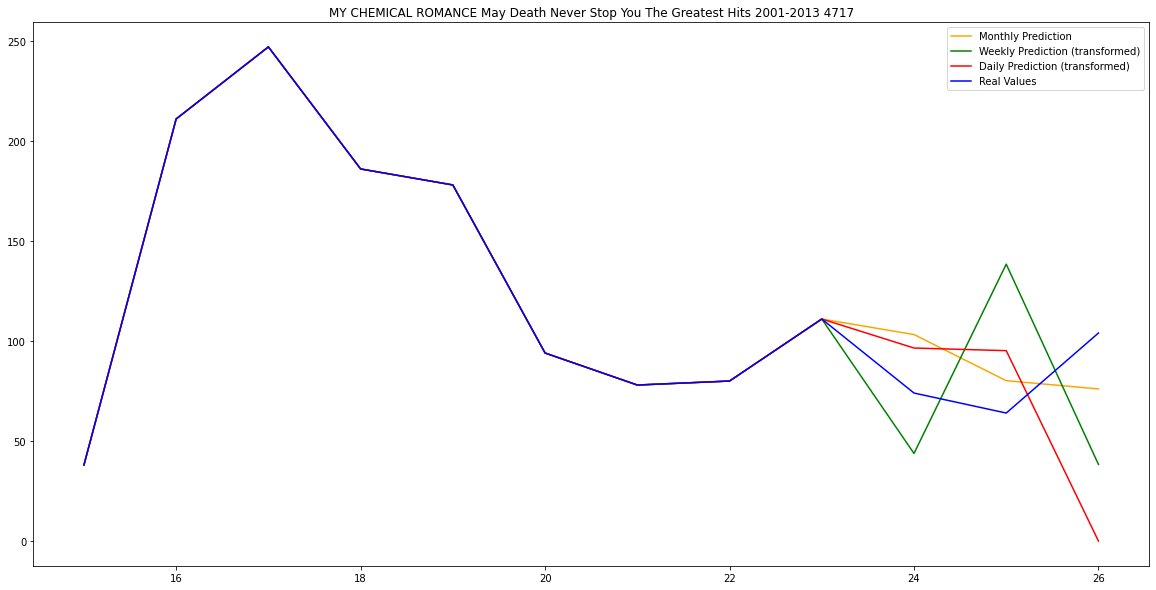

In [288]:
import imp
import random
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
random_product = random.choice(to_use)
real_data = products_complete[products_complete['prod_id']==random_product]
while not all(elem in real_data.month_id.values.tolist() for elem in [24,25,26]) or random_product not in test_datos_ventas_mensuales.prod_id.values.tolist():
    random_product = random.choice(to_use)
    real_data = products_complete[products_complete['prod_id']==random_product]

real_data['pred_mensual'] = real_data['total_units_sold']
real_data['pred_mensual'].iloc[-3:] = compute_out_monthly(random_product)
real_data['pred_semanal'] = real_data['total_units_sold']
real_data['pred_semanal'].iloc[-3:] = compute_out_weekly(random_product)
real_data['pred_diaria'] = real_data['total_units_sold']
data = compute_out_daily(random_product)
real_data['pred_diaria'].iloc[-3:] = data


figure(figsize=(20,10))
plt.plot(real_data.month_id.values,real_data.pred_mensual.values, label = 'Monthly Prediction', c = 'orange')
plt.plot(real_data.month_id.values,real_data.pred_semanal.values, label = 'Weekly Prediction (transformed)', c = 'green')
plt.plot(real_data.month_id.values,real_data.pred_diaria.values, label = 'Daily Prediction (transformed)', c = 'red')
plt.plot(real_data.month_id.values,real_data.total_units_sold.values, label = 'Real Values', c = 'blue')
plt.title('{} {}'.format(products_db.loc[products_db['prod_id'] == random_product].prod_name.values[0],random_product)) 
plt.legend() 


Por posibles problemas de visualización se importan 4 productos diferentes. La carpeta de Resultados/Imagenes contiene mas ejemplos a inspeccionar.
La imagenes muestran ventas frente al month id del dataset

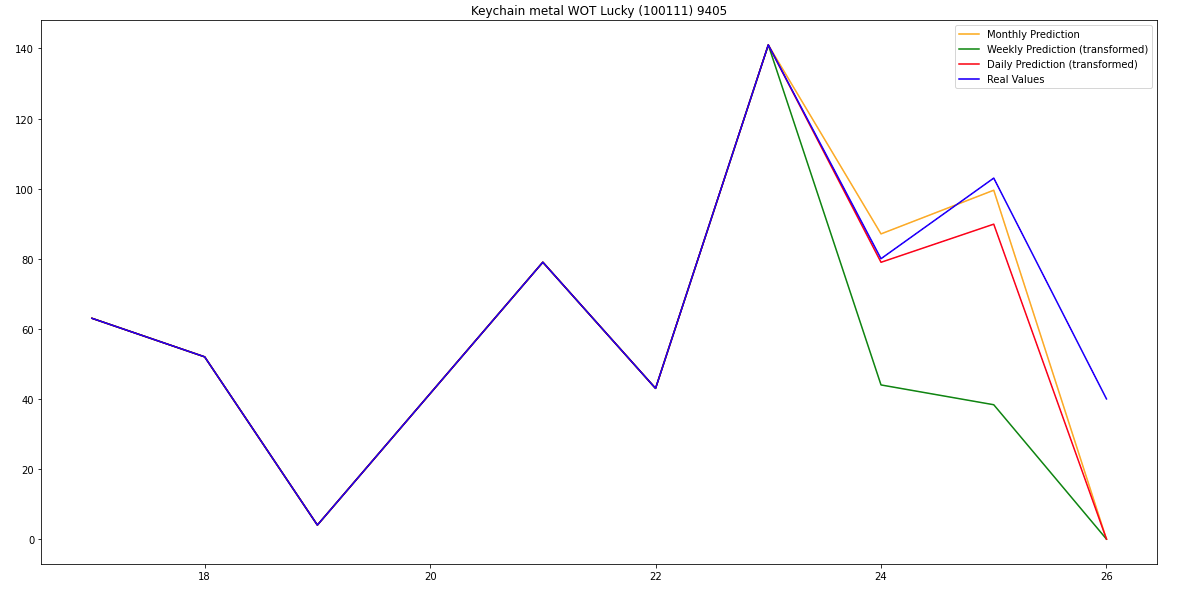

In [4]:
from IPython.display import Image
Image("Resultados/Images/visualizacion1.png")

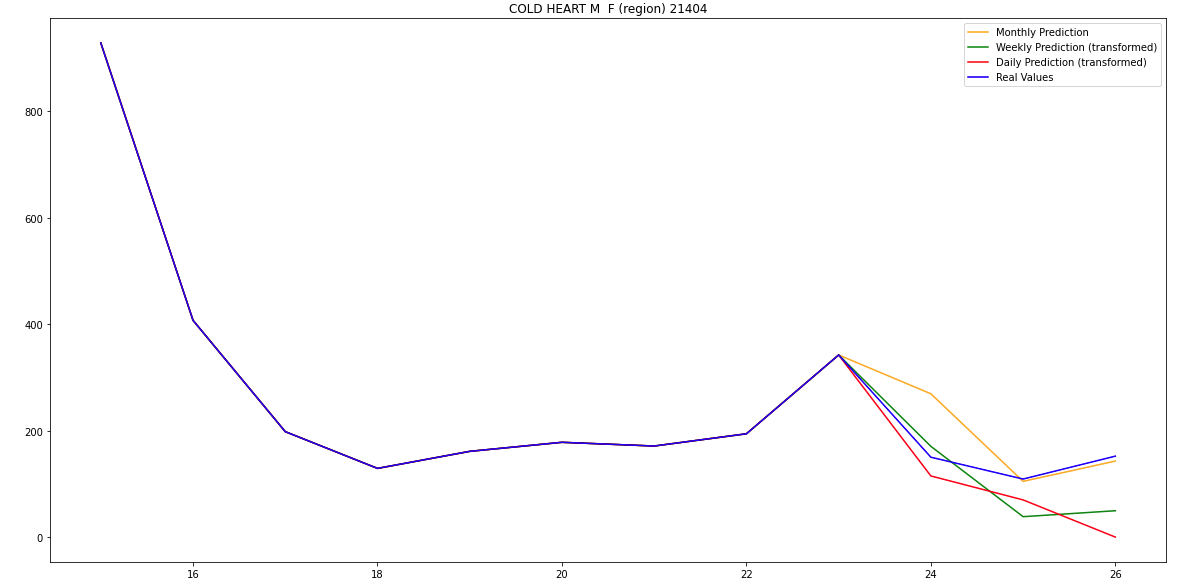

In [5]:
Image("Resultados/Images/visualizacion2.png")

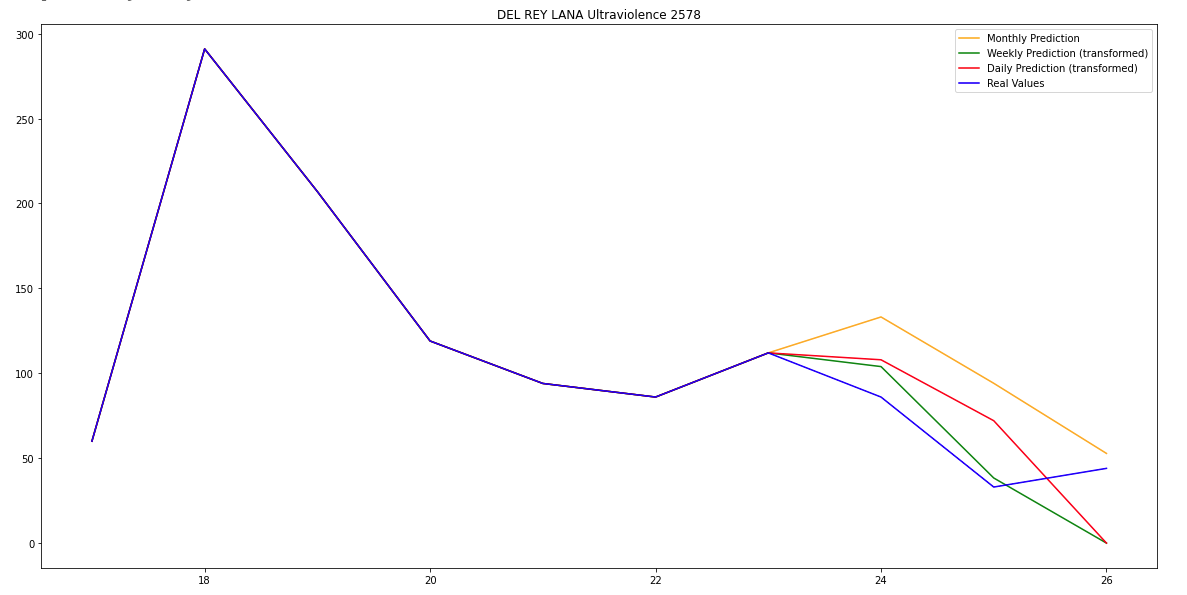

In [6]:
Image("Resultados/Images/visualizacion3.png")

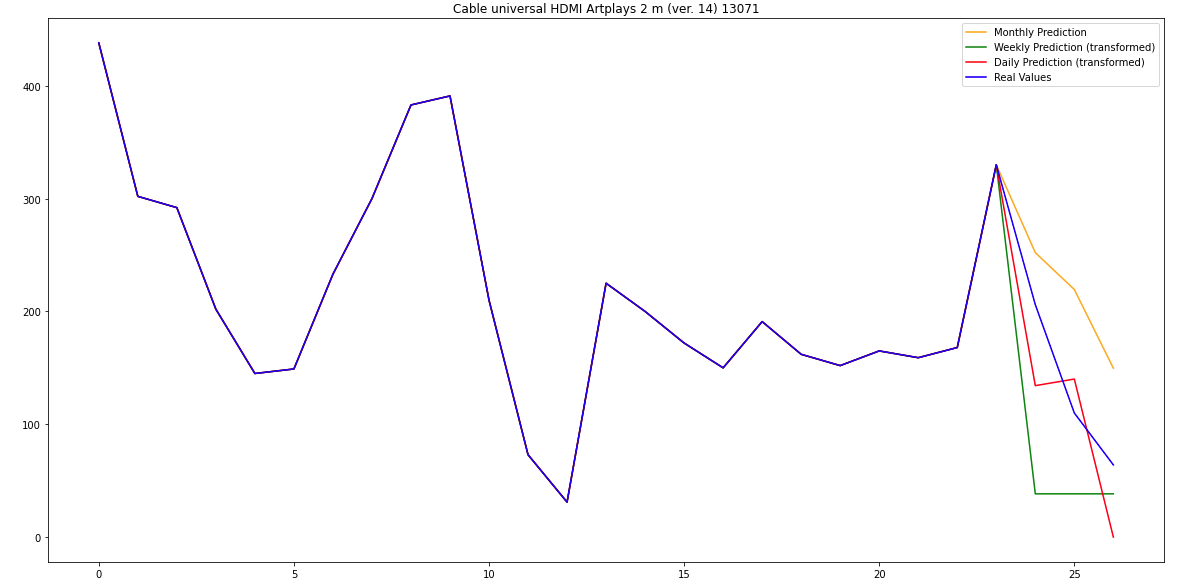

In [7]:
Image("Resultados/Images/visualizacion4.png")

Todas las imágenes previas muestran que el modelo es capaz de detectar la tendendia que van a tener las ventas del los productos, es posible que no acierte siempre en el valor pero sus movimientos estan correctamente atajados.